In [1]:
# ------------------------------------------#
#        Expt 5: Perform a battery of negative inference tests from a single script and plot results, save metadata    
# ------------------------------------------#

Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
end 

┌ Warning: Error requiring `LazyArrays` from `DistributionsAD`
│   exception =
│    LoadError: UndefVarError: ValueSupport not defined
│    Stacktrace:
│      [1] top-level scope
│        @ ~/.julia/packages/DistributionsAD/GGe2E/ext/DistributionsADLazyArraysExt.jl:15
│      [2] include(mod::Module, _path::String)
│        @ Base ./Base.jl:419
│      [3] include(x::String)
│        @ DistributionsAD ~/.julia/packages/DistributionsAD/GGe2E/src/DistributionsAD.jl:1
│      [4] top-level scope
│        @ ~/.julia/packages/Requires/Z8rfN/src/Requires.jl:40
│      [5] eval
│        @ ./boot.jl:368 [inlined]
│      [6] eval
│        @ ~/.julia/packages/DistributionsAD/GGe2E/src/DistributionsAD.jl:1 [inlined]
│      [7] (::DistributionsAD.var"#398#411")()
│        @ DistributionsAD ~/.julia/packages/Requires/Z8rfN/src/require.jl:101
│      [8] macro expansion
│        @ timing.jl:382 [inlined]
│      [9] err(f::Any, listener::Module, modname::String, file::String, line::Any)
│        @ Require

In [2]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [3]:
filename

"/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"

In [4]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [5]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

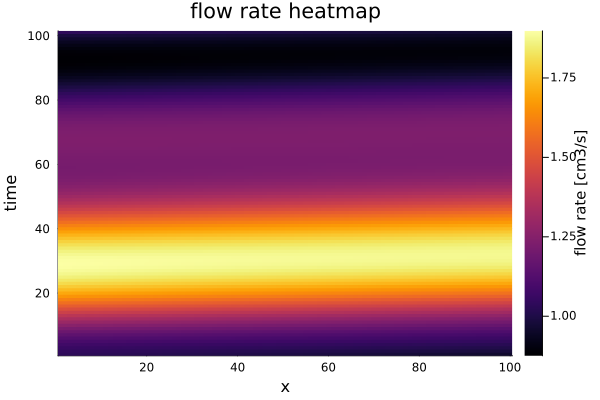

In [6]:
heatmap(data1d_fix[:,:,20,1], title="flow rate heatmap", cbar_title = "flow rate [cm3/s]")
xlabel!("x")
ylabel!("time")


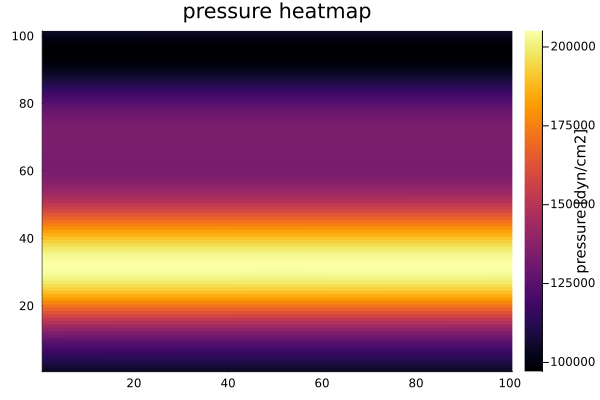

In [7]:
heatmap(data1d_fix[1:end,:,20,2], title="pressure heatmap", cbar_title = "pressure [dyn/cm2]")

In [8]:
begin
    global dt = 0.01                     # time step
    global T = 1                      # total time
    global tsteps = 0.0:dt:T             # discretized time dimension
    global tspan = (0,T)                 # end points of time integration for ODEProbem

    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.005         # learning rate , currently using PolyOpt default (0.1)


end

0.005

In [9]:
waveforms = 1

1

In [10]:
u0 = data1d_fix[1,:,1:waveforms,1];
u01 = data1d_fix[1,:,1,1];

In [11]:
ytrain2 = data1d_fix[:,:,1:waveforms,1];
ytrain21 = data1d_fix[:,:,1,1];


In [12]:
bc_flow = data1d_fix[:,1,:,1];
bc_flow1 = bc_flow[:,1];

In [13]:
size(ytrain21)

(101, 100)

In [14]:
N = size(u01,1)
# NN embedded in PDE for Differential programming
ann = Chain(
            Dense(N,50,tanh),
            Dense(50,50,tanh),
            Dense(50,50,tanh),
            Dense(50,N));

In [15]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 15250


In [16]:
# function learn_1DBlood(u, p, t, bc_left)
#     Φ = re(p) # restructure flattened parameter vector into NN architecture.
#     # Apply boundary conditions
#     u[1] = bc_left(t)
#     return Φ(u)
# end



function learn_1DBlood(u, p, t)
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    

    output = Φ(u)
    return output
end



learn_1DBlood (generic function with 1 method)

In [17]:
# Define time-dependent boundary conditions
function bc_left(t, bc_flow1)
    # Define the value of the boundary condition at the left boundary for a given time t

    # Find the two closest points in bc_flow1
    #caculate the time index that's closest to time t
    t_index = Int(floor(t / dt)) + 1
    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dt) / dt

    # Perform linear interpolation
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == T
        bc_interp = bc_flow1[t_index]
        
    else
        bc_interp = (1 - t_frac) * bc_flow1[t_index] + t_frac * bc_flow1[t_index + 1]
    end
    
    return bc_interp
end


# Define time-dependent boundary condition function
bc_left_func(t) = bc_left(t, bc_flow1)

bc_left_func (generic function with 1 method)

In [18]:
#define learning problem.
learn_1DBlood_prob(u01,tspan) =  ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), u01, tspan, p)


learn_1DBlood_prob (generic function with 1 method)

In [31]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/hardcodeBC_testNODE"
working_dir = output_dir
# calculate and save the untrained solution 
begin 
    learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), u01, tspan, p)     # p changes after training   
    if ode_solver == "Tsit5"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "RK4"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    elseif ode_solver == "Rosenbrock23"
        sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
    end
    save_object(output_dir*"/sol_learn_testNODE_untrained.jld2",sol_learn_1DBlood_untrained)
    println("saved untrained solution")
end 

saved untrained solution


In [32]:
prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), u01, tspan, p) ;
function predict(θ,prob,bc_left,dt)
    if ode_solver == "Tsit5"
        sol = Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "RK4"
        sol = Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
    elseif ode_solver == "Rosenbrock23"
        sol = Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
    end
    
    #hardcode boundary conditions after the neural network output
    multiply = Float32.(vcat(zeros(size(sol)[2])',ones(size(sol)[1]-1,size(sol)[2])))
    add = Float32.(vcat(bc_left',zeros(size(sol)[1]-1,size(sol)[2])))
    
    
    return sol.*multiply.+add
end 

predict (generic function with 1 method)

In [33]:
# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [34]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [35]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [36]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:Tsit5


In [41]:
# restart training from previaous checkpoint if it exists, else start 
# fresh training.
if !isnothing(path_checkpoint)
    checkpoint_exists = isfile(path_checkpoint)
    if checkpoint_exists
        println("Checkpoint exists!")
        ckpt_restart = jldopen(path_checkpoint,"r")
        res1 = ckpt_restart["ckpt"]
        uinit = copy(res1.u)
    else
        println("ckpt path given, but no file found!")
    end
else
    uinit = deepcopy(ps)
    println("Fresh training initialized")
end

Fresh training initialized


Start training epoch 1
time: 1/1
time: 2
Using ADAM optimizer
Sum of params:19.72776
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 1119.1314680666135
Iteration: 2 || Loss: 1012.5713528013825
Iteration: 3 || Loss: 857.1382156351934
Iteration: 4 || Loss: 786.6626391777869
Iteration: 5 || Loss: 735.4911478478975
Iteration: 6 || Loss: 735.4911478478975
saving ADAM checkpoint...
Sum of params:-1.1989517
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 735.4911478478975
Iteration: 2 || Loss: 686.4613510998436
Iteration: 3 || Loss: 673.5215573799969
Iteration: 4 || Loss: 662.840170951326
Iteration: 5 || Loss: 651.090699998394
Iteration: 6 || Loss: 643.9752127858821
Iteration: 7 || Loss: 636.8412687242727
Iteration: 8 || Loss: 631.6606119659286
Iteration: 9 || Loss: 628.6710221450695
Iteration: 10 || Loss: 626.8885371909885
Iteration: 11 || Loss: 625.6884871921201
Iteration: 12 || Loss: 625.2808950880336
Iteration: 13 || Loss: 625.01332204078

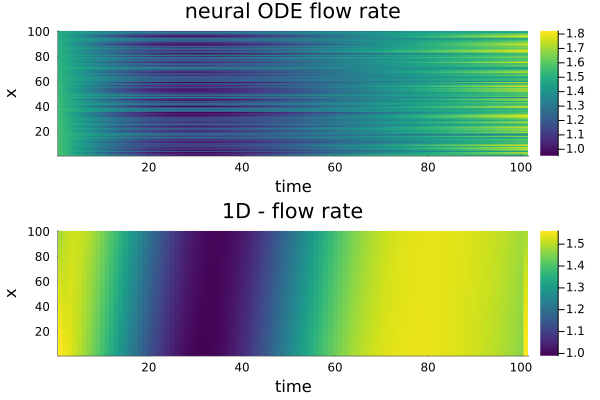

Epoch 1 mean loss:134.53493127134539
Start training epoch 2
time: 1/1
time: 2
Using ADAM optimizer
Sum of params:-62.706047
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 134.53493127134539
Iteration: 2 || Loss: 17736.641157582846
Iteration: 3 || Loss: 1589.8796283203988
Iteration: 4 || Loss: 1967.5138940193997
Iteration: 5 || Loss: 2678.6850264369496
Iteration: 6 || Loss: 134.53493127134539
saving ADAM checkpoint...
Sum of params:-62.706047
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 134.53493127134539
Iteration: 2 || Loss: 133.4623123198018
Iteration: 3 || Loss: 130.95042295730386
Iteration: 4 || Loss: 127.88843367592361
Iteration: 5 || Loss: 123.77135465506663
Iteration: 6 || Loss: 120.06145149585153
Iteration: 7 || Loss: 115.0409292364443
Iteration: 8 || Loss: 109.22265088279224
Iteration: 9 || Loss: 103.96229860889838
Iteration: 10 || Loss: 94.80620021480036
Iteration: 11 || Loss: 84.77363926594299
Iteration: 12 || Loss: 80.6

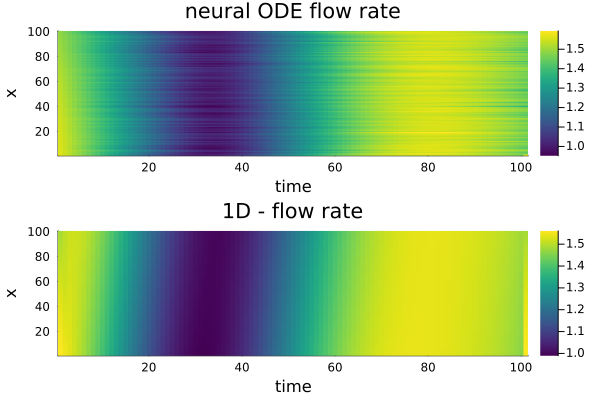

Epoch 2 mean loss:9.550957630717011
Start training epoch 3
time: 1/1
time: 2
Using ADAM optimizer
Sum of params:-60.54715
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 9.550957630717011
Iteration: 2 || Loss: 8457.64519208226
Iteration: 3 || Loss: 219.07828239573197
Iteration: 4 || Loss: 3501.126830345296
Iteration: 5 || Loss: 961.9453711994314
Iteration: 6 || Loss: 9.550957630717011
saving ADAM checkpoint...
Sum of params:-60.54715
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 9.550957630717011
Iteration: 2 || Loss: 9.548049538007517
Iteration: 3 || Loss: 9.523477711408535
Iteration: 4 || Loss: 9.43390100453946
Iteration: 5 || Loss: 9.374028653703151
Iteration: 6 || Loss: 9.24798149684986
Iteration: 7 || Loss: 9.10222513497487
Iteration: 8 || Loss: 9.00998635713769
Iteration: 9 || Loss: 8.905536637036525
Iteration: 10 || Loss: 8.809432388648926
Iteration: 11 || Loss: 8.680857221759286
Iteration: 12 || Loss: 8.55918531240777
Iterati

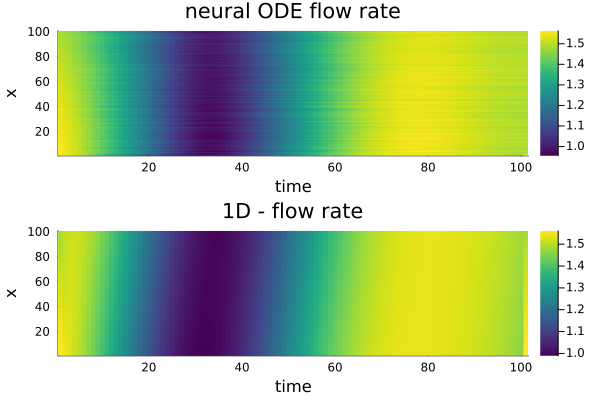

Epoch 3 mean loss:4.166487462485191
Start training epoch 4
time: 1/1
time: 2
Using ADAM optimizer
Sum of params:-60.46865
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 4.166487462485191
Iteration: 2 || Loss: 20583.65032201833
Iteration: 3 || Loss: 4406.207687936382
Iteration: 4 || Loss: 4821.171296016812
Iteration: 5 || Loss: 3927.537032619801
Iteration: 6 || Loss: 4.166487462485191
saving ADAM checkpoint...
Sum of params:-60.46865
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 4.166487462485191
Iteration: 2 || Loss: 4.163543959817601
Iteration: 3 || Loss: 4.16235225439832
Iteration: 4 || Loss: 4.156531693559152
Iteration: 5 || Loss: 4.13840840169174
Iteration: 6 || Loss: 4.125716494040214
Iteration: 7 || Loss: 4.097300589959004
Iteration: 8 || Loss: 4.085490072366525
Iteration: 9 || Loss: 4.045999501991698
Iteration: 10 || Loss: 4.028014968594453
Iteration: 11 || Loss: 3.9983478304633024
Iteration: 12 || Loss: 3.9508484550531136
It

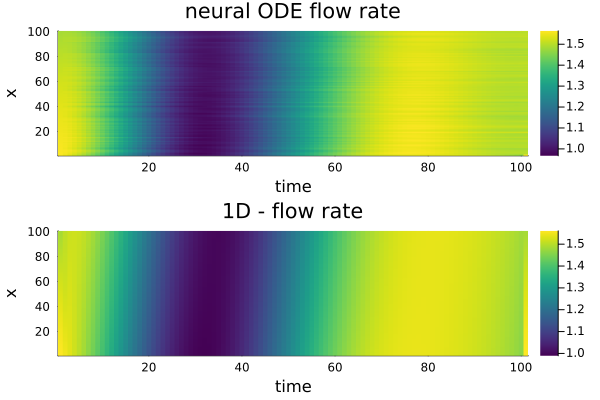

Epoch 4 mean loss:2.245887002588547
Start training epoch 5
time: 1/1
time: 2
Using ADAM optimizer
Sum of params:-65.28209
Max iters:5
Choosing ADAM Optimizer.
Iteration: 1 || Loss: 2.245887002588547
Iteration: 2 || Loss: 49974.96789232601
Iteration: 3 || Loss: 9954.28098103738
Iteration: 4 || Loss: 5382.587402448806
Iteration: 5 || Loss: 1494.4446988997743
Iteration: 6 || Loss: 2.245887002588547
saving ADAM checkpoint...
Sum of params:-65.28209
Switching to BFGS optimizer
Max iters:50
Choosing BFGS Optimizer.
Iteration: 1 || Loss: 2.245887002588547
Iteration: 2 || Loss: 2.245433777474906
Iteration: 3 || Loss: 2.2422522018727
Iteration: 4 || Loss: 2.241301268537363
Iteration: 5 || Loss: 2.2350587872331213
Iteration: 6 || Loss: 2.234129679890162
Iteration: 7 || Loss: 2.221457478365245
Iteration: 8 || Loss: 2.2085312050159533
Iteration: 9 || Loss: 2.1915124903377636
Iteration: 10 || Loss: 2.1838913911299818
Iteration: 11 || Loss: 2.169759504848605
Iteration: 12 || Loss: 2.1513490266213475

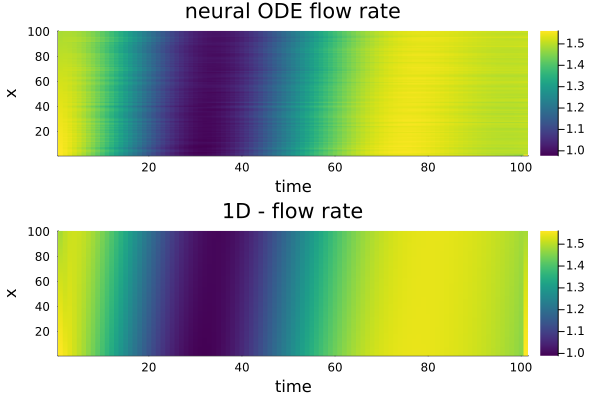

Epoch 5 mean loss:1.3210210647527787


In [42]:
n_epochs = 5

#set time horizon settings
nt = 100
n_samples = Int(100/nt)+1
list_loss_train = []

for j in 1:n_epochs
    loss_tot = 0.0
    println("Start training epoch ",j)
    for i in 1:size(ytrain2,3)
        for k in 2:n_samples
        println("time: ",k-1, "/",n_samples-1)
            
        T = dt * nt  # total time
        tspan = (0.0, T)
        tsteps = 0:dt:tspan[2]  # create time vector
            
        function predict(θ,prob,bc_left,dt)
            if ode_solver == "Tsit5"
                sol = Array(solve(prob,Tsit5(),p=θ,dt=dt,saveat=dt))
            elseif ode_solver == "RK4"
                sol = Array(solve(prob,RK4(),p=θ,dt=dt,saveat=dt))
            elseif ode_solver == "Rosenbrock23"
                sol = Array(solve(prob,Rosenbrock23(),p=θ,dt=dt,saveat=dt))
            end
                
            #hardcode boundary conditions to the NN output!
            multiply = Float32.(vcat(zeros(size(sol)[2])',ones(size(sol)[1]-1,size(sol)[2])))
            add = Float32.(vcat(bc_left',zeros(size(sol)[1]-1,size(sol)[2])))


            return sol.*multiply.+add
            return sol
        end     
        
        function loss(θ, ytrain21, prob, bc_left,dt)
            pred = predict(θ, prob, bc_left,dt)
            l = sum(abs2, pred[:,:] - ytrain21)
            
            return l, pred
        end
            
            
        prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), ytrain2[(k-2)*nt+1,:,i], tspan, p);
        optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob, bc_flow[(k-2)*nt+1:(k-1)*nt+1,i],dt),adtype) ;
        println("time: ",k)
        println("Using $optimizer_choice1 optimizer")
        println("Sum of params:", sum(uinit))
        uinit = train_loop(uinit,adtype,optf,train_maxiters,learning_rate,optimizer_choice1)
        println("Sum of params:", sum(uinit))
            
        if !isnothing(optimizer_choice2)
            println("Switching to $optimizer_choice2 optimizer")

            uinit = train_loop(uinit,adtype,optf,train_maxiters*10,learning_rate,optimizer_choice2)

            println("Sum of params:", sum(uinit))


            println("Completed training:" ,i)
        else
            println("Completed training:" ,i)
        end

        prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), ytrain2[(k-2)*nt+1,:,i], tspan, p);
        l , pred = loss(uinit,ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]',prob, bc_flow[(k-2)*nt+1:(k-1)*nt+1,i],dt)
        loss_tot = loss_tot + l
        println("Final BFGS loss:",l)
        push!(list_loss_train, l)
            
            
        # plot solution for comparison
        plot1 = heatmap(pred[:,:], color=:viridis, title = "neural ODE flow rate")
        xlabel!("time")
        ylabel!("x")

        plot2 = heatmap(ytrain2[(k-2)*nt+1:(k-1)*nt+1,:,i]', title="1D - flow rate", color=:viridis)
        xlabel!("time")
        ylabel!("x")
        display(plot(plot1,plot2,layout = (2, 1)))
        sleep(1)    
        
            
            
        end
    end
    
    push!(list_loss_train, loss_tot/size(ytrain2,3))
    println("Epoch ", j, " mean loss:", loss_tot/size(ytrain2,3))
end

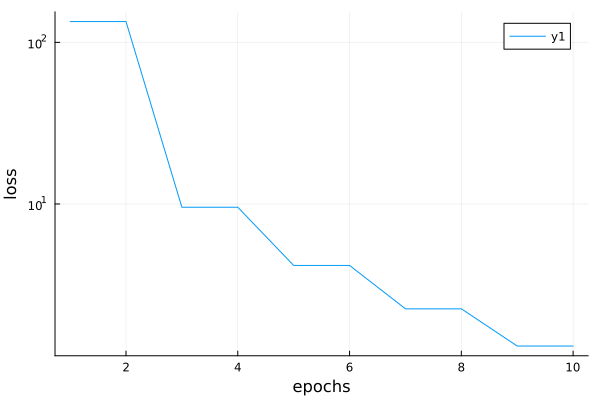

In [44]:
plot(list_loss_train, yaxis=:log)
ylabel!("loss")
xlabel!("epochs")

### Load the final learnt parameters and do inference ###

### All at once inference ###

In [80]:
# p_learn = load("/home/tschala/research/LANL/testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 5
# u01 = u0[:,wv]
# p = p_learn["p"]

# T = 1                      # total time
# tsteps = 0.0:dt:T             # discretized time dimension
# tspan = (0,T)    

# begin 
# #     bc_left_func(t) = bc_left(t, bc_flow[:,wv])
     
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), u01, tspan, p);     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/testNODE/output/sol_learn_testNODE_trained.jld2");
# solution = sol_learn["single_stored_object"]
# # multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# # add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# # sol = solution.*multiply.+add
    

# sol = solution
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

saved trained solution


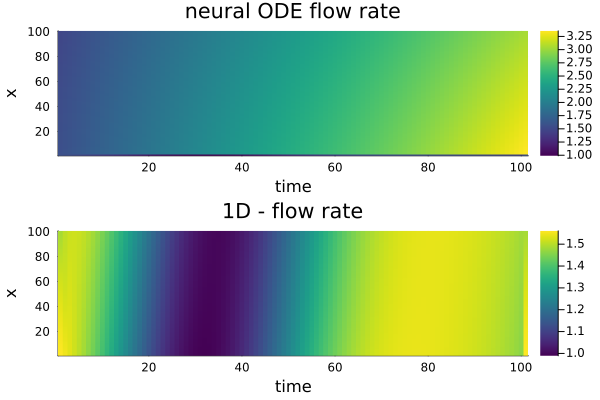

In [40]:
# p_learn = load("/home/tschala/research/LANL/testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# begin 
# #     bc_left_func(t) = bc_left(t, bc_flow[:,wv])
     
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), u01, tspan, p);     # p changes after training   
#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")
# end

# sol_learn = load("/home/tschala/research/LANL/testNODE/output/sol_learn_testNODE_trained.jld2");
# solution = sol_learn["single_stored_object"]
# multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
# add = Float32.(vcat( bc_flow[:,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
# sol = solution.*multiply.+add
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))

### Step-by-step inference ###

In [30]:
# p_learn = load("/home/tschala/research/LANL/testNODE/ptrained_BFGS.jld2")
# #waveform to evaluate
# wv = 1
# u01 = u0[:,wv]
# p = p_learn["p"]

# nt = 100
# T = dt * nt  # total time
# tspan = (0.0, T)
# tsteps = 0:dt:tspan[2]  # create time vector  

0.0:0.01:1.0

In [32]:
# sol_list = []
# for k in 1:1
#     println("t:",k*dt)
#     #     bc_left_func(t) = bc_left(t, bc_flow[:,wv])

# #     if k ==1 
#     learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), u01, tspan, p);     # p changes after training   
# #     else
# #         #Fix
# # #         u01 = sol_learn["single_stored_object"][:,2]
# #         learn_1DBlood_prob_untrained(u01,tspan) = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t), u01, tspan, p);
# #     end

#     if ode_solver == "Tsit5"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Tsit5(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "RK4"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),RK4(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     elseif ode_solver == "Rosenbrock23"
#         sol_learn_1DBlood_untrained = Array(solve(learn_1DBlood_prob_untrained(u01,tspan),Rosenbrock23(),alg_hints=[:stiff], dt=dt, saveat=dt, reltol=1e-20)); # save on intervals for which we will train on, dt2 
#     end
#     save_object(output_dir*"/sol_learn_testNODE_trained.jld2",sol_learn_1DBlood_untrained)
#     println("saved trained solution")

#     sol_learn = load("/home/tschala/research/LANL/testNODE/output/sol_learn_testNODE_trained.jld2")
#     println("sol loaded")
#     solution = sol_learn["single_stored_object"]
#     u01 = solution[:,2]
#     multiply = Float32.(vcat(zeros(size(solution)[2])',ones(size(solution)[1]-1,size(solution)[2])))
#     add = Float32.(vcat( bc_flow[k,wv]',zeros(size(solution)[1]-1,size(solution)[2])))
#     sol = solution.*multiply.+add
#     push!(sol_list,sol)

# end

# combined_sol = hcat(sol_list...);

# sol = combined_sol[:,2:2:end];

t:0.01
saved trained solution
sol loaded


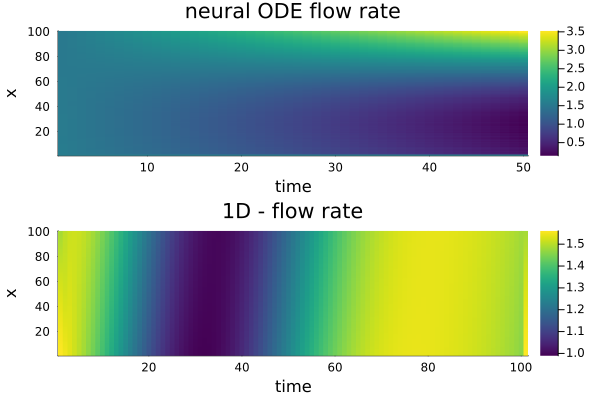

In [33]:
# plot1 = heatmap(sol[:,:], color=:viridis, title = "neural ODE flow rate")
# xlabel!("time")
# ylabel!("x")

# plot2 = heatmap(ytrain2[:,:,wv]', title="1D - flow rate", color=:viridis)
# xlabel!("time")
# ylabel!("x")

# plot(plot1,plot2,layout = (2, 1))